In [1]:
from nilearn.masking import compute_epi_mask, compute_brain_mask
from nilearn.image import load_img, mean_img, resample_to_img
from nilearn.plotting import plot_roi
from nilearn.masking import apply_mask
from nilearn.datasets import load_mni152_template, load_mni152_brain_mask

/home/morteza/micromamba/envs/MultiModalRest/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


/home/morteza/micromamba/envs/MultiModalRest/lib/python3.10/site-packages/nilearn/image/resampling.py:597: UserWarning: Casting data from int16 to float32
  warnings.warn(f"Casting data from {data.dtype.name} to {aux}")


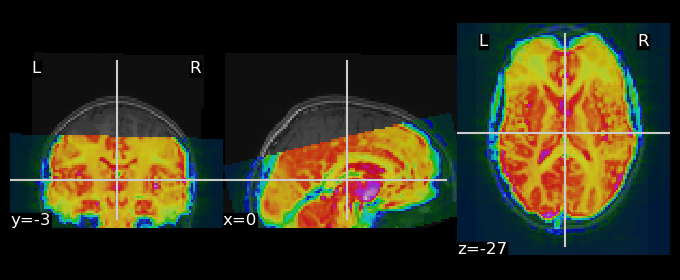

In [2]:
t2 = load_img('data/openneuro/ds004697/sub-001/ses-1/func/sub-001_ses-1_task-rest_bold.nii.gz')
t1 = load_img('data/openneuro/ds004697/sub-001/ses-1/anat/sub-001_ses-1_T1w.nii.gz')


# t2_mean = mean_img(t2)
# t1_mask = compute_brain_mask(t1)

mni152 = load_mni152_template(resolution=2)
from nilearn.image import resample_img

t1 = resample_to_img(t1, mni152)

# t1_mask = compute_brain_mask(t1)
# t1 = resample_to_img(t1, mni152)
# rs_img_mean = resample_to_img(rs_img_mean, mni152)

t2 = resample_to_img(t2, t1)
# t2 = resample_img(t2, mni152.affine, mni152.shape)
t2_mean = mean_img(t2)

# from nilearn.image import clean_img
# t2 = clean_img(t2, detrend=False, standardize=False, low_pass=None, high_pass=None, t_r=2)

plot_roi(t2_mean, t1)

In [3]:
import nibabel as nib

# align using dipy
# from dipy.align.transforms import AffineTransform3D
# from dipy.align.imaffine import AffineRegistration
# affreg = AffineRegistration()
# t2_affine = affreg.optimize(mni152.get_fdata(), t2_mean.get_fdata(), AffineTransform3D(), params0=None)
# t1_reg = nib.Nifti1Image(t2_affine.transform(t2_mean.get_fdata()),
#                          t2.affine, t2.header)

Brain extraction:  retrieving model weights.
Brain extraction:  retrieving template.
Brain extraction:  normalizing image to the template.
Brain extraction:  prediction and decoding.
1/1 [==============================] - 4s 4s/step
Brain extraction:  renormalize probability mask to native space.


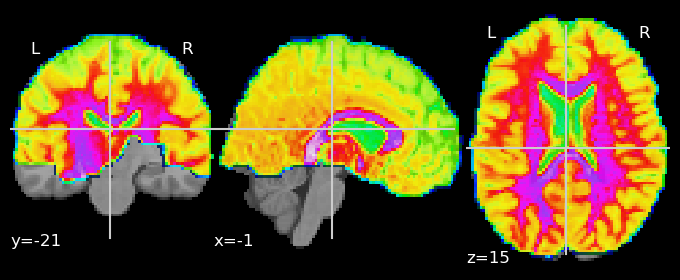

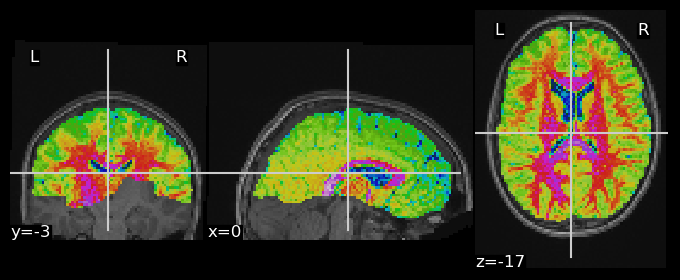

In [45]:
import ants
import antspynet

mni152_ants = ants.from_nibabel(mni152)
t1_ants = ants.from_nibabel(t1)
t1_mni = ants.resample_image_to_target(t1_ants, mni152_ants, True, 0)

t1_brain_mask = antspynet.brain_extraction(t1_ants, modality='t1', verbose=True)
t1_brain_ants = ants.mask_image(t1_ants, t1_brain_mask)
t1_brain = ants.to_nibabel(t1_brain_ants)

t1_reg_ants = ants.registration(ants.from_nibabel(mni152),
                                t1_brain_ants,
                                type_of_transform='AffineFast'
                                )['warpedmovout']


t1_reg = ants.to_nibabel(t1_reg_ants)
plot_roi(t1_reg, mni152, alpha=.9)
plot_roi(t1_brain, t1)

Brain extraction:  retrieving model weights.
Brain extraction:  retrieving template.
Brain extraction:  normalizing image to the template.
Brain extraction:  prediction and decoding.
1/1 [==============================] - 3s 3s/step
Brain extraction:  renormalize probability mask to native space.


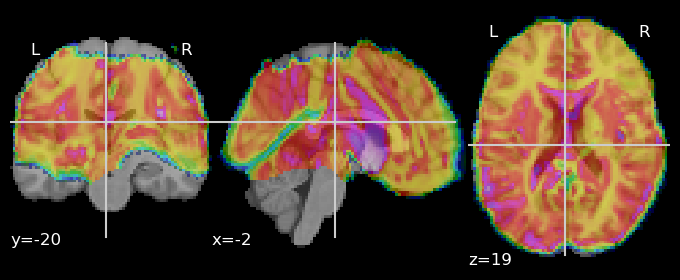

In [46]:
t2_ants = ants.resample_image_to_target(ants.from_nibabel(t2), t1_reg_ants, imagetype=3)
t2_mean_ants = t2_ants.get_average_of_timeseries()

t2_brain_mask = antspynet.brain_extraction(t2_mean_ants, modality='bold', verbose=True)

t2_mean_ants = ants.mask_image(t2_mean_ants, t2_brain_mask)

t2_reg_ants = ants.registration(t1_reg_ants,
                                t2_mean_ants,
                                type_of_transform='SyN'
                                )['warpedmovout']
t2_reg = ants.to_nibabel(t2_reg_ants)
plot_roi(t2_reg, mni152, alpha=.5)

In [ ]:
# adapted from from ANTsR brain extraction

# def brain_extract(img):
#     bm_img = ants.threshold_image(img, "Otsu", 3 )
#     bm_img = ants.threshold_image( bm_img,  2, 3 )
#     bm_img = ants.iMath(bm_img, "ME", 1)
#     bm_img = ants.iMath(bm_img, "GetLargestComponent")
#     bm_img = ants.iMath(bm_img, "MD", 1)
#     bm_img = ants.iMath(bm_img, "ME", 1)
#     return bm_img

# t1_brain = brain_extract(t1)

# t1_brain.plot()